# CVA Calculation for an Interest Rate Swap

- Calculate the credit valuation adjustment to the price of an interest rate swap using the credit spreads for Counterparty B.
- Plot MtM values (a good plot will show results from many simulations)
- Produce smoothed Expected Exposure prodile using the mean of the exposure distribution - distribution of Forward LIBORs at each time $T_i+1$.
- Produce Potential Future Exposure with the simulated $L_6M$ taken from the $97.5^{th}$ percentile.

The details for the IRS are as follows:

Recovery Rate = 40%

Tenor = 5Y

Payments Frequency = 6M

MtM Position = Floating Leg - Fixed Leg

Counterparty A = Sovereign UK (http://data.cnbc.com/quotes/GBCD5) -> 43.00

Counterparty B = Sovereign Germany (http://data.cnbc.com/quotes/DECD5) -> 20.245

Credit spread value as per CNBC = 22.755 basis points (0.2275%)

We will need to compute:

- Fwd LIBOR rates (via monte carlo)
- Discount Factors
- Exposure
- Expected Exposure

And once we have all of those parts we will be able to determine the CVA (Credit Valuation Adjustment) for the interest rate swap outlined above.

### Forward LIBOR

To provide the $L_6M$ structure, we will generate the Forward LIBOR using _One Factor Libor Market Model_, described in 'Advanced Quantative Finance', Alonso Peña. 

I have a particular interest in parallel and GPU based computing so I took it as an opportunity to rewrite the reference material in Python to aid integration with the CUDA GPU library provided by nVidia (https://developer.nvidia.com/cuda-toolkit) and also the Intel MKL libraries for optimized Math functions on intel processors. These are conveniently provided by the default install of Anaconda (http://www.continuum.io) and are utilitised under the thirty day free trial.


In [2]:
import numpy as np
import accelerate as acc
from app.gpuCheck import getGpuCount

from accelerate.cuda.rand import PRNG, QRNG

gpuEnabled = False # gpu acceleration is not available in jupyter..
debug = False # code here is pretty much commented so set to false here..

# print 'Checking for compatible GPU ...'
# if getGpuCount() < 1:
#     print 'no compatible GPU installed, will revert to using numpy libraries for RNG'
# else:
#     print 'nVidia GPU(s) found: ', getGpuCount()
#     print 'Enabling GPU for RNG'
#     gpuEnabled = True

The notebook itself runs the normal versions of this, if you are interested in running the GPU enabled versions. You will need an NVidia GFX card with compute capability of greater than 2.0 and have installed the latest cuda drivers. Once installed you can run the python files from disk.

### Utility functions

Let's setup some utility functions for random number generation. (the CUDA code is included here but commented out since it will cause kernel panics in Jupyter)

In [8]:
def getPseudoRandomNumbers_Uniform(length):
    """

    generates a an array of psuedo random numbers from uniform distribution using numpy

    :param length:
    :return:
    """
    rand = []
    for i in range(length):
        rand[i] = np.random.uniform(0., 1.)
    return tuple(rand)

def getBoxMullerSample():
    t = 1.0
    while t >= 1.0 or t == 0.0:
        x, y = getPseudoRandomNumbers_Uniform(2)
        t = np.square(x) + np.square(y)
    result = x * np.sqrt(-2 * np.log(t) / t)
    return result


# def getPseudoRandomNumbers_Uniform_cuda(shape=tuple):
#     """

#     generates a an array of psuedo random numbers from uniform distribution using CUDA

#     :param length:
#     :return:
#     """
#     prng = PRNG(rndtype=PRNG.XORWOW)
#     rand = np.empty(100000)
#     prng.uniform(rand)

#     return rand[:length]


# def getSOBOLseq_cuda(length=int):
#     """

#     returns an nd array of supplied length containing a SOBOL sequence of int64

#     only for use on systems with CUDA libraries installed

#     :param length:
#     :return ndarray:
#     """
#     qrng = QRNG(rndtype=QRNG.SOBOL64)
#     rand = np.ndarray(shape=100000, dtype=int)
#     qrng.generate(rand)

#     return rand[:length]



### Calculate Credit Default Swap Spreads

In order to infer the correct lambda to use, we need to calculate the spread value for the CDS. 

So for the value of the default leg, we will use:

$PV(default) = \sum_{i=1}^{T_i}N . (1-R) . DF_i . PD(T_i,T_{i-1}) $

$PV(premium) = \sum_{i=1}^{T_i} \pi . N . \Delta t . DF_i . PD(T_i) $

Bootstrapping the hazard rates using the formula below:

$\lambda_k = \frac{-1}{\Delta t} ln ( \frac{P(T_{k-1}D(0,T_k)(1-R)+\sum{n=1}^{k-1}}{} ) $



To encapsulate this I have created the CDS class below:

In [5]:
x,y = np.cumsum(getPseudoRandomNumbers_Uniform(2))
y = np.cumsum(np.random.randn(n))

In [6]:
k = 10  # We add 10 intermediary points between two 
        # successive points.
# We interpolate x and y.
x2 = np.interp(np.arange(n*k), np.arange(n)*k, x)
y2 = np.interp(np.arange(n*k), np.arange(n)*k, y)

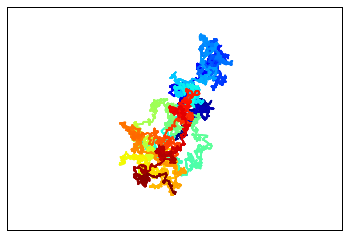

In [7]:
# Now, we draw our points with a gradient of colors.
plt.scatter(x2, y2, c=range(n*k), linewidths=0,
            marker='o', s=3, cmap=plt.cm.jet,)
plt.axis('equal');
plt.xticks([]); plt.yticks([]);

In [ ]:
fixed=0.39
floating="3M"
tenor="12M"
## payments at 3 months
payment=0.25
notional=1000000
## bootstrapped from credit default spreads for the counterparty
spread=0.3 
recoveryRate=0.4


next we need the forward rates and the discount factors.

$L_I = S_I$

$L1 = \frac{S_iT_i - S_{i-1}T_{i-1}}{T_i-T_{i-1}}$

Forward rates can be derived from the spot rates in continous time.


In [ ]:
import math

""" spot rate data from: 
https://www.treasury.gov/resource-center/data-chart-center/interest-rates/Pages/Historic-Yield-Data-Visualization.aspx"""
spotRates = [(1, 0.01), 
             (3, 0.02), 
             (6, 0.07), 
             (1*12,      0.48),
             (2*12,      0.64),
             (3*12,      0.76),
             (5*12,      1.08)]
def forwardRateFromSpot(item):
    print item
def generateForwardRateCurve(spotRateData=list):
    spotRateData.map(forwardRateFromSpot, range(1, len(spotRate))
def discountFactor(spotRate,fwdRate):
    return math.exp(-fwdRate*spotRate)


#### Discount Factors
$DF_i = exp(-S_iT_i)$

#### Default Probabilities
$PD_i = exp(-\lambda T_{i-1}) -exp(-\lambda T_i)\quad \forall i = 1,2,3,4$

### References

[1] _'The One Factor Libor Market Model Using Monte Carlo Simulation: An Empirical Investigation'_, Pena, di Sabatino,Ligato,Ventura,Bertagna. Dec 2010

[2] _'Advanced Quantitative Finance with C++'_, Pena. 2014

[3] _'Python for Finance'_, Yves Hilpisch. 2014

[4] _'emscriptem'_, http://kripken.github.io/emscripten-site/. - C++ to JavaScript compiler.

[5] _'VisPy'_, http://cyrille.rossant.net/compiler-data-visualization/

[3] _'Title'_, Author, (Mon YYYY)
